In [11]:
from seagul.rl.ars.ars_pipe import ars
from seagul.nn import MLP
import torch
import matplotlib.pyplot as plt
from seagul.mesh import create_mesh, variation_dim, mesh_dim, BylMesh
import time
import copy
import gym


import xarray as xr
import numpy as np
import pandas as pd

import os

from sklearn.decomposition import PCA

In [12]:
def identity(rews,obs,acts):
    return rews

def vardiv(rews, obs, acts):
    return rews/variation_dim(obs)

def varmul(rews, obs, acts):
    return rews*variation_dim(obs)

def rough_measure(x):
    d = torch.stack([x[t,:] - x[t-1,:] for t in range(1,x.shape[0])])
    return d.std()#$/(torch.abs(d.mean()))

def rmul(rews, obs, acts):
    return rews*rough_measure(obs)

def rdiv(rews, obs, acts):
    return rews/rough_measure(obs)

def do_rollout(env, policy, render=False):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while not done:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        if render:
            env.render()
            input("step?")
            #time.sleep(.05)

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length


def do_long_rollout(env, policy, ep_length):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while cur_step < ep_length:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length

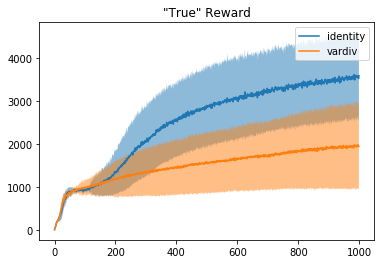

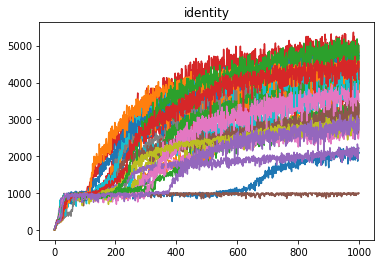

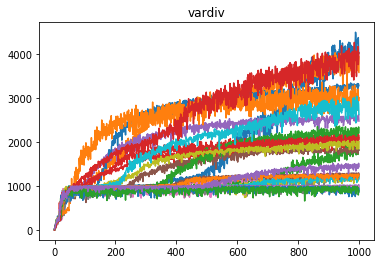

<Figure size 432x288 with 0 Axes>

In [13]:
def reward_fn(s):
    if s[3] > 0:
        if s[0] >= 0 and s[2] >= 0:
            #reward = np.clip(np.sqrt(s[0]**2 + s[2]**2),0,10)
            reward = 5.0
            #reward = 5 - np.clip(np.abs(np.sqrt(s[0]**2 + s[2]**2) - 5)**2,0,5)
            s[3] = -10
        else:
            reward = 0.0

    elif s[3] < 0:
        if s[0] <= 0 and s[2] <= 0:
            #reward = np.clip(np.sqrt(s[0]**2 + s[2]**2),0,10)
            #reward = 5 - np.clip(np.abs(np.sqrt(s[0]**2 + s[2]**2)**2 - 5),0,5)
            reward = 5.0
            s[3] = 10
        else:
            reward = 0.0

    return reward, s

data = torch.load("./data5/Walker2d-v2.xr")

policy_dict = data.policy_dict
rews = data.rews
exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
num_seeds = len(policy_dict['identity'])

#policy_dict = torch.load("./data/mjw_longermul.pol_dict")
#rews = torch.load("./data/mjw_longermul.data")

means = rews.mean(dim="trial")
stds = rews.std(dim="trial")

plt.plot(means.T)
plt.legend(exp_names)
ci = stds

for mean, c in zip(means, ci):
    plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
plt.title("\"True\" Reward")
plt.figure()

for exp_name in exp_names:  
    plt.plot(rews.loc[exp_name].T)
    plt.title(exp_name)
    plt.figure()

running build_ext


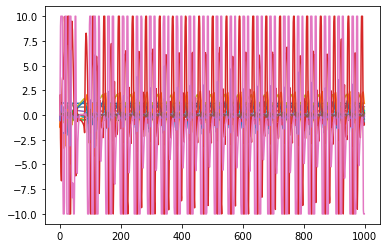

In [15]:
import seagul.envs
env_name = "Walker2d-v2"

policy = policy_dict['vardiv'][3]
env = gym.make(env_name)
#o,a,r,l = do_long_rollout(env, policy, ep_length= 10000)
o,a,r,l = do_rollout(env, policy, render=False)

start_idx = 500
plt.plot(o)
target = o[start_idx:]
target = (target - target.mean(dim=0))/target.std(dim=0)


In [5]:
init_d = 1e-6
num_runs = 1
post_fns = [identity, vardiv, rmul]

msize1 = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

msize2 = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

msize4 = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

mdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

cdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

vdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

rdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})


for post_fn in post_fns:
    for i in range(num_seeds):
        for j in range(num_runs):
            policy = policy_dict[post_fn.__name__][i]
            o,a,r,l = do_long_rollout(env, policy, ep_length=10000)
            target = o[500:]
            target = (target - target.mean(dim=0))/target.std(dim=0)
            #m,w = create_mesh(target,init_d)
            #assert(len(m) == len(target))
            
            m = create_mesh_dict(target,1)
            msize4.loc[post_fn.__name__,i,j] = len(m)
            
            m = create_mesh_dict(target,.1)
            msize2.loc[post_fn.__name__,i,j] = len(m)
            
            m = create_mesh_dict(target,.01)
            msize1.loc[post_fn.__name__,i,j] = len(m)

            mdims.loc[post_fn.__name__,i,j] ,  cdims.loc[post_fn.__name__,i,j], _ = mesh_dim(target, init_d)
            vdims.loc[post_fn.__name__,i,j] = variation_dim(target)
            rdims.loc[post_fn.__name__,i,j] = rough_measure(target).item()



NameError: name 'identity' is not defined

In [1]:
msize1.mean(dim='seed')

NameError: name 'msize1' is not defined

In [8]:
msize2.mean(dim='seed')

<xarray.DataArray (post: 3, run: 1)>
array([[9254.7],
       [8852.9],
       [9240.7]])
Coordinates:
  * post     (post) <U8 'identity' 'vardiv' 'rmul'
Dimensions without coordinates: run

In [16]:
msize4.mean(dim='seed')

<xarray.DataArray (post: 3, run: 1)>
array([[1637.2],
       [1352. ],
       [1408.2]])
Coordinates:
  * post     (post) <U8 'identity' 'vardiv' 'rmul'
Dimensions without coordinates: run

In [22]:
vdims.std(dim='seed')

<xarray.DataArray (post: 3, run: 1)>
array([[0.19176825],
       [0.19054744],
       [0.20116548]])
Coordinates:
  * post     (post) <U8 'identity' 'vardiv' 'rmul'
Dimensions without coordinates: run

In [10]:
cdims.mean(dim='seed')

<xarray.DataArray (post: 3, run: 1)>
array([[0.],
       [0.],
       [0.]])
Coordinates:
  * post     (post) <U8 'identity' 'vardiv' 'rmul'
Dimensions without coordinates: run

In [13]:
from seagul.mesh import BylMesh
import numpy as np

m = BylMesh(.1)
a = np.random.random(4)
m[a] = 1

print(a in m)
print(len(m))

True
1


In [18]:
# HalfCheetah-v2
def my_reset(env, point):
    env.reset()
    qpos = np.concatenate((np.array([0.0]), point[:8]))
    qvel = point[8:]
    env.unwrapped.set_state(qpos, qvel)
    return env.unwrapped._get_obs()

# TODO
means = np.array([-0.1493, -0.0530,  0.2734,  0.2111,  0.1695, -0.1920, -0.1085, -0.0560,
     5.6835, -0.0199, -0.0328,  0.1103, -0.0753,  0.3667, -0.1152, -0.5202, -0.5898])

stds = np.array([ 0.0201,  0.0819,  0.2858,  0.4369,  0.4530,  032.5282,  0.1319,  0.4039,
     0.5005,  0.3914,  2.3088,  7.8874, 10.6420, 10.1966, 13.9180,  4.4428, 10.5551])

def create_mesh_obs(env, policy, d, seed_point, perturbs):
    torch.autograd.set_grad_enabled(False)
    
    failure_point = np.ones_like(seed_point)*10
    
    mesh = BylMesh(d) 
    mesh[seed_point] = []
    mesh[failure_point] = []
    
    mesh_points = []
    mesh_points.append(seed_point)
    
    cnt = 0
    for cur_base in mesh_points:
        for pert in perturbs:
            cnt+=1
            init_pos = cur_base + pert
            o = my_reset(env, init_pos)

            step = 0
            done = False;
            set_mesh = False
            
            while not done:
                a = policy(o); step+=1
                
                last_o = copy.copy(o)
                o, r, done, _ = env.step(a.numpy())
                
                if (o[3] > .5 and o[12] < 0.0 and last_o[12] > 0.0 and step > 2):
                    target = ((o - means)/stds)
                    
                    if target in mesh:
                        mesh[target].append(init_pos)
                    else:
                        mesh[target] = [init_pos]
                        mesh_points.append(mesh.__keytransform__(o))
                    
                    if cnt % 100 == 0:
                        print(len(mesh), cnt)
                        
                    done=True
                    set_mesh=True
                        
                if step > 65:
                    done=True
                    
            if done and not set_mesh:
                mesh[init_pos] = [failure_point]
                            
    torch.autograd.set_grad_enabled(True)
    return mesh, mesh_points

def create_mesh_act(env, policy, d, seed_point, perturbs):
    torch.autograd.set_grad_enabled(False)
    
    failure_point = np.ones_like(seed_point)*10
    
    mesh = BylMesh(d) 
    mesh[seed_point] = []
    mesh[failure_point] = []
    
    mesh_points = []
    mesh_points.append(seed_point)
    
    cnt = 0
    for cur_base in mesh_points:
        for pert in perturbs:
            cnt+=1
            init_pos = cur_base
            o = my_reset(env, init_pos)

            step = 0
            done = False;
            set_mesh = False
            do_once=1 
            while not done:
                a = policy(o) + do_once*pert
                step+=1
                do_once=0
                
                last_o = copy.copy(o)
                o, r, done, _ = env.step(a.numpy())
                
                if (o[3] > .5 and o[12] < 0.0 and last_o[12] > 0.0 and step > 1):
                    target = ((o - means)/stds)
                    
                    if target in mesh:
                        mesh[target].append(init_pos)
                    else:
                        mesh[target] = [init_pos]
                        mesh_points.append(o)
                    
                    if cnt % 100 == 0:
                        print(len(mesh), cnt)
                        
                    done=True
                    set_mesh=True
                        
                if step > 6:
                    done=True
                    
            if done and not set_mesh:
                mesh[init_pos] = [failure_point]
                            
    torch.autograd.set_grad_enabled(True)
    return mesh, mesh_points


In [19]:
perts =  np.random.uniform(-.01,.01,(10,6))
#perts = np.zeros((100,17))

o = env.reset()
last_o = copy.copy(o)

step = 0
done=False
while not done:
    a = policy(o).detach(); step+=1
    o, r, done, _ = env.step(a.numpy())
    if (o[3] > .5 and o[12] < 0.0 and last_o[12] > 0.0 and step > 100):
        seed_point = o
        done=True
        
    last_o = copy.copy(o)

mesh, mesh_points = create_mesh_act(env, policy, .5, seed_point, perts)

NameError: name 'pca' is not defined

In [99]:
perts =  np.random.uniform(-0.1,0.1,(2,6))
policy = policy_dict["identity"][0]

#perts = np.zeros((100,17))

o = env.reset()
step = 0
done=False
while not done:
    a = policy(o).detach(); step+=1
    o, r, done, _ = env.step(a.numpy())
    if (o[3] > .6 and o[12] < 0.0 and step > 50):
        seed_point = o
        done=True

mesh, mesh_points = create_mesh_act(env, policy, .5, seed_point, perts)

100 100
196 200
285 300
358 400
438 500
505 600
590 700
671 800
743 900
818 1000
891 1100
958 1200
1023 1300
1094 1400
1167 1500
1234 1600
1302 1700
1366 1800
1436 1900
1494 2000
1555 2100
1618 2200
1678 2300
1734 2400
1796 2500
1847 2600
1910 2700
1959 2800
2011 2900
2055 3000
2111 3100
2166 3200
2220 3300
2275 3400
2332 3500
2385 3600
2437 3700
2494 3800
2545 3900
2592 4000
2637 4100
2694 4200
2743 4300
2796 4400
2843 4500
2887 4600
2943 4700
2983 4800
3040 4900
3082 5000
3128 5100
3170 5200
3214 5300
3261 5400
3303 5500
3349 5600
3390 5700
3434 5800
3482 5900
3523 6000
3567 6100
3614 6200
3655 6300
3697 6400
3743 6500
3794 6600
3843 6700
3883 6800
3921 6900
3962 7000
4000 7100
4041 7200
4083 7300
4129 7400
4181 7500
4236 7600
4275 7700
4317 7800
4362 7900
4404 8000
4439 8100
4487 8200
4523 8300
4555 8400
4592 8500
4634 8600
4668 8700
4714 8800
4752 8900
4792 9000
4832 9100
4866 9200
4909 9300
4951 9400
4982 9500
5020 9600
5062 9700
5104 9800
5150 9900
5196 10000
5234 10100
5281 1020

In [19]:
seed = 0
for post_name in ['identity' ,'vardiv' , 'rmul']: #seed = 10
    for run in [0,1,2,3,4]:
        o,a,r,l = do_long_rollout(env,policy_dict[post_name][seed], ep_length=10000)

        #print("reward:", sum(r))
        #print("variation_dim: ", variation_dim(o))
        #print("roughness: ", rough_measure(o))
        #plt.plot(o)
        #plt.figure()
        #plt.plot(a)

        import scipy.io 
        import os

        o = np.array(o)
        a = np.array(a)
        r = np.array(r)
        os.makedirs(f"./k/env_{env_name}/post_{post_name}/seed_{seed}", exist_ok=True)
        scipy.io.savemat(f"./k/env_{env_name}/post_{post_name}/seed_{seed}/run_{run}.mat", mdict = {"obs":o, "act":a, "rew":r})

In [138]:
on = np.zeros(obs.shape[0])
for i,o in enumerate(obs):
    on[i] = (o[3] > .5 and o[12] < 0.0 and last_o[12] > 0.0 and step > 10)
    last_o = copy.deepcopy(o) 

In [139]:
dl = []
last_seen = 0
for i,o in enumerate(on):
    if o == 1:
        dl.append(i-last_seen)
        last_seen = i

In [140]:
dd = {}
for d in dl:
    if (d) in dd: 
        dd[(d)] += 1
    else:
        dd[(d)] = 1

In [141]:
dd

{31: 1, 5: 1522, 6: 223, 4: 224, 10: 3, 11: 4, 12: 1, 22: 1, 14: 1}

In [2]:
from sklearn.decomposition import PCA
env_name = "HalfCheetah-v2"

policy = policy_dict['vardiv'][3]
env = gym.make(env_name)
o,a,r,l = do_long_rollout(env, policy, ep_length= 1000)
#o,a,r,l = do_rollout(env, policy, render=True)

start_idx = 500
plt.plot(o[start_idx:])
target = o[start_idx:]
#target = (target - target.mean(dim=0))/target.std(dim=0)

NameError: name 'policy_dict' is not defined

In [ ]:
#target = np.random.random((100,17))
pca = PCA()
pca.fit(np.array(target))

#target = np.random.random((100,17))
target = np.array(o[start_idx:])
pca = PCA()
pca.fit(np.array(target,dtype=np.float64))

array([0.18301552, 0.09429376, 0.04575285, 0.00337166, 0.        ])